## Deep Denoising Compressive Autoencoder

<p> Author: Qasim Wani <br> Date written: Nov. 25, 2020 </p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import time
import os

from keras.datasets import mnist
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

Using TensorFlow backend.


## Step 1. loading data

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
print(f"Train data shape {X_train.shape}")
print(f"Test data shape {X_test.shape}")

Train data shape (60000, 28, 28)
Test data shape (10000, 28, 28)


## Step 2. Gaussian Noise

In [3]:
def noise(img):
    """
    Standard gaussian model for adding noise to an image.
    @Param:
    1. img - (nd.array) image to add noise to.
    @Return:
    - img - output of gaussian noise with mean = 0, variance = 1.
    """
    return img + np.random.normal(0, 10, img.shape)

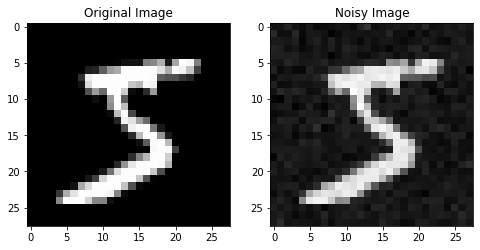

In [4]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1), plt.imshow(X_train[0], 'gray'), plt.title("Original Image")
plt.subplot(1, 2, 2), plt.imshow(noise(X_train[0]), 'gray'), plt.title("Noisy Image")
plt.show()

In [5]:
def generate_noisy_dataset(feature_matrix):
    """
    Generates noisy dataset of images.
    @Param:
    1. feature_matrix: (nd.array) original/clean images.
    @Returns:
    - noisy_data: dirty/noisy images after applying gaussian noise function.
    """
    noisy_data = []
    for img in feature_matrix:
        noisy_data.append(noise(img))
    return np.array(noisy_data).reshape(feature_matrix.shape)

In [6]:
noisy_X_train = generate_noisy_dataset(X_train)
noisy_X_test = generate_noisy_dataset(X_test)

## Step 3. Autoencoder model

In [7]:
class DAE(nn.Module):
    """Defines the Denoising Autoencoder model"""
    def __init__(self, image_size=(28, 28), fc1=256, fc2=128, bottleneck=64):
        """
        Initialize encoder and decoder model.
        @Param: 
        1. image_size: height and width of input image, tuple (m, n), where m is height and n is width.
        2. fc1: number of hidden units for first fully connected layer.
        3. fc2: number of hidden units for second fully connected layer.
        4. bottleneck: number of hidden units for bottleneck (codes) layer.
        """
        super(DAE, self).__init__()
        m, n = image_size
        self.encoder = nn.Sequential(
                  nn.Linear(m * n, fc1),
                  nn.ReLU(True),
                  nn.Linear(fc1, fc2),
                  nn.ReLU(True),
                  nn.Linear(fc2, bottleneck),
                  nn.ReLU(True)
                  )
        #build decoder as reconstruction filter.
        self.decoder = nn.Sequential(
                      nn.Linear(bottleneck, fc2),
                      nn.ReLU(True),
                      nn.Linear(fc2, fc1),
                      nn.ReLU(True),
                      nn.Linear(fc1, m * n),
                      nn.Sigmoid(),
                      )
        
    def forward(self, x):
        """Override forward pass by incorporating encoder and decoder network architecture"""
        x = self.encoder(x) #compress image
        x = self.decoder(x) #reconstruction
        return x

In [8]:
#Enable cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
model = DAE()
# according to paper, lossy image compression with compressive autoencoders (https://arxiv.org/pdf/1703.00395.pdf)
# they used MSE loss as a measure of distortion b/w reconstruction and original image
### Note that original image ≠ input image.
loss = nn.MSELoss()
# paper uses Adam optimizer for regularization with default Adam hyperparameters. keeping it as is for now.
optimizer = optim.Adam(model.parameters())

## Step 4. Training the model

In [10]:
def train(feature_matrix, labels, epochs=int(1e2), epsilon=0.5):
    """
    Trains Autoencoder based on noisy images and corresponding labels
    @Param:
    1. feature_matrix: (nd.array) tuple representing (noisy_images, original_images).
    2. labels: (nd.array[int]) labels corresponding to feature_matrix
    3. epochs: (int) number of iterations
    4. epsilon: (float) stopping condition
    """
    noisy, original = feature_matrix
    cost = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for dirty, clean in zip(noisy, original):
            dirty = torch.from_numpy(dirty).float().squeeze(0).flatten().to(device)
            clean = torch.from_numpy(clean).float().squeeze(0).flatten().to(device)
            
            output = model(dirty) #get output from forward pass.
            loss_output = loss(output, clean) #generate MSE error
            
            optimizer.zero_grad() #clean gradients
            loss_output.backward() #backprop
            optimizer.step()
            
            running_loss += loss_output.item()
        
        #append costs
        cost.append(running_loss)
        
        if(running_loss < epsilon):
            break

    return cost

In [ ]:
feature_matrix = (noisy_X_train, X_train) #generate overall feature matrix
cost = train(feature_matrix, y_train)